# MetSIM Model Fitting
## 1. Setup
## 2. Phenotype Data Import and Normalization
## 3. Feature Selection
## 4. Phenotype Matrix Decomposition
## 5. Methylation Import
## 6. PC Removal to Control Cell Type Composition Differences Between Samples
## 7. RRBS Training/Test Split
## 8. Randomized Lasso
## 9. CV Regression Model
## 10. Data Export for GREAT Annotation
## 11. Figures

## 1. Setup

In [12]:
# Set directory path and to data cleaning tools

working_directory = '../pwd'
base_path = '../pwd'

In [13]:
# Library import
import numpy as np
import seaborn as sns
import pandas as pd
import random
import scipy
import sys 
import random

In [14]:
# import normalization code and kNN code
sys.path.append(ewas_tools)
from data_cleanup import *
#from kNNimputer import *

In [15]:
# provide list of methylation sequencing samples (saves memory, don't import the methylation data until necessary)
rrbs_samples = ['2273', '2320', '2368', '2403', '2421', '2436', '2469', '2480', '2481', '1796', '1813', '1944', '2129', '2226', '2230', '2262', '2264', '1208', '1234', '1280', '1301', '1436', '1517', '1530', '1738', '1744', '718', '758', '787', '816', '1004', '1049', '1058', '1082', '1147', '377', '379', '441', '495', '6564', '6632', '6639', '6807', '535', '539', '634', '635', '697', '10886', '10280', '10377', '10390', '10437', '10406', '10548', '10567', '10664', '10879', '7366', '7432', '7604', '7626', '10012', '10016', '10039', '10070', '10071', '1148', '1452', '1545', '1674', '1768', '1896', '2057', '2348', '1559', '1165', '1678', '1455', '5521', '1777', '2100', '1932', '6854', '6875', '7096', '7136', '2430', '5530', '1264', '1457', '1580', '1702', '1779', '1942', '2103', '2529', '5571', '1303', '1462', '1583', '1722', '1822', '1974', '2176', '2655', '5812', '1409', '1483', '1590', '1725', '1840', '1984', '2242', '2656', '5833', '1438', '1490', '1599', '1736', '1841', '1987', '2261', '2760', '5849', '1445', '1502', '7295', '5242', '5283', '5365', '1619', '1747', '1885', '1999', '2267', '5273', '5859', '1446', '1518', '1653', '1757', '1891', '2290', '2044', '5462', '5919', '1449', '1524', '1666', '1764', '1892', '2048', '2321', '5470', '6194', '6514', '6515', '6537', '6648', '6666', '6684', '6761', '5922', '6083', '6101', '6183', '6200', '6203', '6277', '6283', '5392', '5481', '5668', '5949', '6425', '5923', '5935', '5951', '5953', '5954', '6005', '6010', '6028', '6041', '6106', '6501', '4479', '4481', '4509', '4518', '4544', '4856', '5084', '5166', '5210', '2513', '2726', '2741', '2743', '2748', '2808', '2902', '4008', '4219', '10177', '10419', '10896', '1111', '2680', '4383', '4410', '520', '522', '5263', '5394', '5460', '569', '5790', '582', '6311', '6737', '6978', '7742', '8219', '844', '845', '874']

In [16]:
# rrbs_samples with a baseline or followup diabetes diagnosis
rrbs_diabetes_samples = ['1944', '1436', '1738', '10280', '2057', '2529', '1841', '1653', '5922', '4383', '5460']

## 2. Whole Cohort Phenotype Data Normalization

In [17]:
# import dataframe and initialize DataCleanup class
whole_cohort_phenotype_data = DataCleanup(working_directory + 'full_cohort_data/METSIM-Baseline-FollowUp-imputed_values.txt', separator='\t')
# transpose phenotype data
whole_cohort_phenotype_data.df = whole_cohort_phenotype_data.df.transpose()
print(len(list(whole_cohort_phenotype_data.df)))

/Users/colinfarrell/Documents/PythonScripts/LMM_EWAS/data_cleanup.py:22: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  imported_data_frame = pd.DataFrame.from_csv(file, sep=separator, header=0, index_col=0)


243


Discard Phenotype Categories that are Directly Indivative of Type2 Diabetes Status

In [18]:
# remove samples with type1 diabetes
whole_cohort_type1 = whole_cohort_phenotype_data.df.loc[whole_cohort_phenotype_data.df['dmtype'] == 1]
type1_list = whole_cohort_type1.index
print(len(type1_list))
whole_cohort_phenotype_data.list_row_removal(type1_list)

25


In [19]:
# Remove feature information colinear with T2D
diabetes_columns_to_remove = ['fmdm',	'dm',	'dmy',	'dmspouse',	'dmtype',	'famdm',	'EUDG',	'allSmpls',	
                              'betabloc',	'nitrate',	'diuretic',	'cachbloc',	'AngRBloc',	'ACEInhib',	'ASA',	
                              'sulfurea',	'metformi',	'insulin',	'glitatso',	'statin',	'statinType',	'fibrate',	
                              'deprmed',	'medcount',	'GLTOL5_6',	'GLTOL6_1',	'DM_AGE',	'DM_YEARS',	'F_dminstreatment',	
                              'F_dminstreatmentdelay',	'F_dm',	'F_dmy',	'F_famdmgrandparents',	'F_famdmfamily',	'F_famdmmother',	
                              'F_famdmfather',	'F_famdmsister',	'F_famdmbrother',	'F_allSmpls',	'F_betabloc',	'F_nitrate',	
                              'F_diuretic',	'F_cachbloc',	'F_AngRBloc',	'F_ACEInhib',	'F_ASA',	'F_sulfurea',	'F_metformi',	
                              'F_insulin',	'F_glitatso',	'F_statin',	'Reimb_DM_date',	'F_Incident_T2DM_2013',	'F_FollowUpTime_T2DM_2013',
                              'F_Incident_T2DM_092014',	'F_FollowUpTime_T2DM_092014',	'TotalT2DM_2013',	'TotalT2DM_092014',	'F_GLTOL5_6',
                              'F_GLTOL6_1',	'F_GLTOL5_6_HbA1c',	'F_DM_AGE',	'F_DM_YEARS',	'D0_dm',	'D0_DMType',	'D0_GLTOL5_6_HbA1c',
                              'D18_DMTYPE', 'FINRISKI', 'QUICKI', 'HOMAIR', 'FINRISKI_CLASSES', 'F_fmdm']

# Categories removed during imputation
categories_removed_in_imputation  = ['dmy', 'statinType', 'DM_AGE', 'DM_YEARS', 'F_dminstreatment',
 'F_dminstreatmentdelay', 'F_dmy', 'Reimb_DM_date', 'F_DM_AGE', 'F_DM_YEARS',
 'D0_dm', 'D0_DMType', 'D0_GLTOL5_6_HbA1c', 'D18_DMTYPE']

for category in categories_removed_in_imputation:
    diabetes_columns_to_remove.remove(category)

print(len(list(whole_cohort_phenotype_data.df)))
whole_cohort_phenotype_data.list_column_removal(diabetes_columns_to_remove)
print(len(diabetes_columns_to_remove))
print(len(list(whole_cohort_phenotype_data.df)))

243
58
185


In [20]:
# transform the dataframe to
whole_cohort_phenotype_data.numeric_data_transformation(errors='coerce')

In [21]:
# remove rows with a lot of missing information
print(len(whole_cohort_phenotype_data.df.index))
#whole_cohort_phenotype_data.remove_low_information_rows(missing_value_tolerance=.25)
print(len(whole_cohort_phenotype_data.df.index))
#low_information_list = whole_cohort_phenotype_data.dropped_row_index

10172
10172


In [22]:
# remove columns with high proportion of missing information
print(len(list(whole_cohort_phenotype_data.df)))
whole_cohort_phenotype_data.remove_low_information_columns(missing_value_tolerance=0.7)
print(len(list(whole_cohort_phenotype_data.df)))

185
185


In [23]:
# missing data imputation
whole_cohort_phenotype_data.standard_imputation(imputation_strategy='median')
whole_cohort_phenotype_data.normal_transformation(normal_test=1000, normal_percentile=0.01)
whole_cohort_phenotype_data.remove_low_variance_features()
print(len(list(whole_cohort_phenotype_data.df)))

184


In [24]:
# for categorical variable I need an unaltered version of the dataframe
whole_cohort_phenotype_data_unaltered = DataCleanup(working_directory + 'full_cohort_data/METSIM-Baseline-FollowUp-D0-D18_2016-03-15.dat.txt', separator='\t')
# drop row data not carried
whole_cohort_phenotype_data_unaltered.list_row_removal([int(x) for x in type1_list])

/Users/colinfarrell/Documents/PythonScripts/LMM_EWAS/data_cleanup.py:22: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  imported_data_frame = pd.DataFrame.from_csv(file, sep=separator, header=0, index_col=0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (19,20,21,22,23,35,36,37,38,39,40,41,44,45,46,47,48,49,50,51,52,53,62,63,64,65,66,67,71,74,77,87,88,89,90,112,113,144,145,146,147,148,156,157,160,161,162,167,168,172) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
# get type2 diabetes label
whole_cohort_diabetes = whole_cohort_phenotype_data_unaltered.df['dmtype']
whole_cohort_diabetes = whole_cohort_diabetes.replace('Healthy', 0)
whole_cohort_diabetes = whole_cohort_diabetes.replace('Type 2 diabetes', 1)

## 3. Feature Selection

In [26]:
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Feature Selection to Maximize distance between healthy and type2 labels

In [27]:
# initialize random logistic regression model for feature selection
# Set extremely lax selection crieteria 
whole_random_log_reg = RandomizedLogisticRegression(sample_fraction=0.75, n_resampling=1000, selection_threshold=.1, scaling=0.5, C=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLogisticRegression is deprecated; The class RandomizedLogisticRegression is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [28]:
phenotype_samples = list(whole_cohort_phenotype_data.df.index)
phenotype_test_samples = random.sample(phenotype_samples, int(len(phenotype_samples) * .6))

In [29]:
phenotype_test_samples = ['892', '4800', '4073', '654', '4601', '5355', '2212', '598', '6141', '136', '4415', '10162', '4826', '10526', '5382', '265', '7871', '11420', '5860', '6886', '1213', '8077', '3850', '1257', '7460', '4413', '7953', '6437', '359', '4117', '621', '1093', '7175', '4443', '6549', '1495', '2589', '5454', '4998', '8269', '6550', '1819', '2314', '603', '5198', '2252', '947', '3853', '7928', '11011', '2568', '2598', '7701', '1917', '10176', '2854', '2425', '5750', '11139', '5903', '10948', '3246', '7086', '4145', '6178', '11042', '7001', '7388', '6271', '1095', '8299', '170', '5027', '3631', '10993', '43', '2608', '6688', '6478', '11116', '10411', '6442', '1799', '6019', '11241', '6258', '5526', '6166', '8399', '7938', '986', '7332', '8053', '10194', '6479', '3734', '11106', '5665', '8284', '5484', '1334', '4930', '10559', '2610', '197', '4768', '4852', '7462', '7402', '3864', '10779', '5997', '10621', '4150', '3251', '710', '925', '4347', '4564', '10846', '7132', '511', '5475', '7330', '6133', '3800', '8273', '10001', '3825', '3971', '3414', '11663', '3074', '4798', '586', '2672', '3719', '11255', '7547', '5761', '8314', '8221', '11343', '3160', '4136', '8153', '7650', '10598', '10392', '11029', '941', '3297', '3575', '4083', '3433', '10345', '1675', '8123', '3434', '420', '5288', '1538', '7583', '4102', '1166', '11581', '11109', '2092', '3360', '2434', '3504', '2356', '2584', '7449', '6833', '10900', '375', '10358', '3420', '3170', '11134', '2787', '1035', '7397', '2505', '2288', '11471', '7099', '122', '121', '3619', '1720', '306', '6466', '11156', '6772', '5831', '5545', '10128', '4868', '7689', '69', '5578', '5277', '6251', '7533', '5805', '1955', '5755', '731', '2605', '3449', '88', '7861', '4916', '2706', '4748', '6733', '1698', '5457', '3385', '8311', '1592', '6697', '6216', '10910', '6552', '11730', '4324', '5562', '6142', '7589', '7356', '10850', '818', '1052', '4502', '5753', '4766', '4238', '481', '887', '10116', '5719', '1645', '2870', '6147', '4267', '3155', '3039', '10518', '3815', '169', '2691', '2508', '10759', '6882', '7902', '4498', '6991', '11380', '1450', '10254', '4312', '195', '10101', '8228', '2853', '6888', '1307', '11393', '4157', '5323', '7364', '2546', '1802', '1359', '4293', '5612', '1356', '156', '8341', '2153', '1585', '4446', '5610', '8164', '2660', '1759', '5078', '2543', '10274', '4467', '3828', '7801', '144', '4487', '6628', '2855', '5797', '10582', '4872', '4015', '1211', '1492', '1355', '2504', '1447', '7759', '779', '1156', '3362', '3661', '3921', '236', '6792', '11792', '2651', '7832', '2573', '7030', '6119', '11790', '11162', '6753', '6262', '7279', '7268', '3544', '7592', '117', '10281', '6155', '1700', '5937', '320', '1890', '2939', '858', '54', '5256', '10103', '2493', '1292', '3113', '2329', '298', '307', '5191', '4164', '3492', '11513', '3875', '5110', '8262', '11731', '7549', '3467', '44', '2818', '1320', '3895', '10066', '1814', '742', '2076', '8033', '4618', '8082', '616', '5456', '4513', '3023', '626', '3805', '8102', '11639', '11168', '3063', '7798', '996', '4317', '10468', '6730', '1774', '2512', '3827', '6686', '3211', '3885', '5634', '1080', '7111', '10615', '10074', '5030', '2452', '2081', '4522', '7430', '11718', '6633', '11768', '7621', '11437', '3212', '2497', '7810', '4085', '1134', '3025', '8379', '4517', '4577', '7754', '8112', '2795', '6811', '4984', '2184', '7091', '3647', '486', '6559', '4168', '6704', '2906', '2326', '3643', '1218', '7480', '10527', '7291', '2722', '5024', '3091', '6914', '3028', '8254', '5443', '1238', '7790', '6594', '10453', '1322', '4337', '5852', '5211', '10032', '6883', '7236', '10220', '507', '3594', '1366', '5823', '4909', '6775', '6694', '5586', '6973', '7712', '4353', '3672', '11332', '2040', '1501', '3563', '4894', '4719', '5769', '5079', '6545', '10998', '413', '6344', '3574', '6131', '11249', '7966', '4354', '5008', '10304', '2992', '5160', '10028', '7918', '421', '4403', '2410', '150', '4989', '705', '338', '8257', '7984', '345', '7867', '5137', '5091', '10729', '363', '3772', '11136', '1623', '4452', '6043', '1902', '3863', '4875', '6426', '7256', '2941', '11563', '1478', '4847', '10996', '7270', '11653', '5055', '6380', '3431', '6740', '432', '8163', '11620', '5925', '7481', '4591', '930', '11727', '945', '5568', '5725', '11537', '3570', '2340', '1270', '11492', '6906', '1087', '5944', '11701', '1251', '3894', '632', '2350', '2445', '3387', '4744', '11450', '7292', '7916', '4135', '4874', '3948', '4642', '3409', '3569', '5414', '4621', '2798', '2009', '3616', '11003', '5311', '808', '7357', '3649', '10330', '2423', '11791', '1200', '10480', '7848', '10487', '7005', '10804', '4537', '2630', '6863', '7335', '8214', '11769', '2412', '4297', '6185', '205', '2089', '3198', '4276', '6242', '1791', '5032', '5148', '7640', '6356', '7911', '8360', '2642', '11470', '5732', '2041', '5', '7101', '542', '119', '2082', '2875', '4290', '10830', '6831', '11183', '5376', '5258', '1812', '572', '11628', '11643', '1730', '4171', '3393', '4458', '1667', '3370', '3797', '8101', '7895', '2705', '10137', '3789', '2712', '969', '6417', '1542', '1125', '6823', '935', '1579', '5427', '10121', '6587', '7405', '7216', '5157', '7788', '981', '6984', '7240', '11071', '6070', '7287', '1363', '1751', '4314', '6905', '8064', '2858', '5364', '7770', '1683', '6669', '3879', '427', '3109', '2740', '5469', '1471', '6274', '7831', '428', '11534', '5656', '8171', '4294', '5389', '489', '2562', '4661', '3867', '11211', '5045', '2833', '736', '11642', '6333', '6592', '10337', '23', '5590', '2486', '4376', '881', '6403', '7889', '6631', '1536', '5344', '5585', '6526', '8366', '6714', '296', '404', '600', '3190', '2526', '10450', '7780', '5791', '4134', '7972', '538', '960', '4988', '7886', '6647', '8004', '2417', '1105', '3034', '4384', '6731', '6373', '5233', '1362', '1880', '8071', '4628', '78', '1121', '3443', '7819', '4709', '4173', '4054', '2335', '10143', '1963', '10605', '3278', '5989', '7582', '6169', '6841', '3931', '10740', '311', '7935', '1279', '11364', '8260', '8098', '1288', '3105', '7671', '4806', '5800', '2790', '7900', '4507', '3015', '11518', '2994', '3851', '11276', '868', '10651', '10303', '3066', '7536', '5109', '11781', '7031', '10240', '2152', '6293', '10164', '4635', '10132', '4643', '2822', '295', '10030', '4614', '683', '4472', '10023', '3571', '4419', '286', '6001', '6668', '227', '573', '2085', '10812', '4213', '458', '6153', '6598', '11340', '6353', '1544', '4952', '6568', '3077', '1793', '4371', '10413', '6377', '5950', '5018', '4751', '7735', '1044', '2072', '10107', '2428', '2155', '268', '2991', '1333', '11644', '6247', '3141', '7686', '3408', '928', '11068', '2219', '11185', '2196', '4900', '2981', '5264', '4943', '11004', '5375', '4211', '6100', '3098', '3276', '8183', '11155', '5354', '11441', '7131', '3290', '10792', '8386', '7338', '7414', '3751', '1807', '4016', '2899', '7696', '6299', '7322', '7409', '7732', '1797', '1325', '4129', '6935', '4110', '2351', '3724', '1696', '2424', '6249', '303', '1523', '10722', '11204', '6076', '317', '90', '4198', '1687', '5076', '143', '3832', '5189', '3136', '6232', '3955', '10867', '11551', '2861', '7612', '10386', '964', '3890', '4588', '4372', '1948', '3626', '277', '7404', '4698', '6847', '4289', '3447', '11394', '5349', '5395', '7815', '931', '6828', '801', '7188', '11355', '6301', '8060', '10682', '3446', '11432', '11735', '1625', '4892', '10055', '3845', '961', '6723', '11167', '11510', '6558', '10186', '11264', '2225', '7991', '6994', '624', '6428', '414', '10643', '6281', '5948', '10371', '10229', '7602', '1889', '7743', '4690', '8230', '7010', '7443', '6430', '2894', '3283', '5549', '7703', '1353', '5237', '8261', '5505', '8321', '2045', '7716', '3872', '10175', '10354', '3530', '5192', '2586', '7245', '4278', '7327', '81', '11726', '6806', '4036', '2439', '7836', '7717', '4152', '5543', '4514', '3768', '2171', '11555', '10961', '11260', '3154', '7646', '8132', '7746', '10263', '7051', '3228', '4407', '6175', '321', '4254', '3286', '5850', '11533', '6851', '2613', '10802', '8135', '10973', '5194', '877', '8282', '5275', '3126', '6849', '6316', '2631', '459', '5483', '11289', '5765', '6204', '5588', '10587', '1565', '3470', '6085', '8088', '622', '753', '10031', '3814', '5709', '5046', '2154', '10169', '8251', '3909', '10052', '7124', '10391', '10561', '4963', '2943', '4623', '1641', '3143', '10610', '10762', '3887', '6756', '7371', '3496', '2014', '5745', '11061', '4721', '11699', '1695', '3548', '15', '1652', '6355', '1191', '4528', '422', '1498', '11734', '1374', '6378', '3725', '606', '400', '4350', '10563', '7765', '5962', '2448', '3411', '4678', '7566', '2747', '76', '476', '6401', '4321', '11013', '11361', '6909', '6327', '3523', '2355', '1879', '11369', '1413', '4815', '7314', '215', '3634', '11753', '2168', '3476', '11233', '6429', '444', '1469', '11461', '7541', '8091', '5915', '6048', '3998', '8365', '5539', '6018', '713', '8281', '6818', '3123', '5758', '6512', '11666', '4454', '4496', '11335', '1430', '3009', '3421', '5195', '6379', '1756', '3858', '2375', '6486', '2733', '4702', '6475', '11724', '942', '11213', '5221', '6880', '11130', '11656', '7108', '2377', '8167', '11257', '11172', '10625', '6800', '1943', '3587', '4375', '1954', '2205', '3344', '4906', '4708', '1096', '3199', '11019', '7434', '1784', '2804', '10009', '5459', '4448', '2276', '7412', '993', '151', '11520', '11744', '3820', '3448', '5402', '5687', '4201', '2249', '135', '344', '581', '7487', '7380', '4042', '608', '10696', '5897', '10724', '6938', '4936', '6484', '364', '8097', '42', '462', '6104', '59', '4682', '10455', '5053', '7954', '7834', '5145', '11207', '10565', '7478', '3340', '1378', '6538', '1335', '7242', '11088', '10448', '4725', '10059', '2385', '2418', '7336', '1271', '387', '7980', '383', '6199', '2207', '5193', '825', '5567', '2766', '1815', '6006', '6672', '5837', '7156', '10384', '10428', '4969', '8396', '5843', '2308', '7611', '7772', '3130', '10684', '246', '1014', '5181', '10155', '7297', '6835', '4738', '7820', '1638', '2576', '10139', '3012', '4542', '5010', '5246', '6422', '5257', '10519', '11593', '326', '5305', '2968', '477', '4040', '5777', '331', '2180', '2727', '1061', '5708', '6525', '855', '11476', '11105', '8356', '2955', '2816', '863', '1863', '242', '976', '1597', '2626', '4301', '6487', '11095', '5615', '7528', '357', '10041', '7817', '1697', '11747', '1273', '11108', '1734', '7498', '4489', '6109', '1655', '7113', '2696', '2331', '6586', '10693', '10974', '4928', '3242', '2221', '4137', '3410', '10586', '1253', '6610', '10034', '3535', '6671', '7586', '10474', '5523', '3794', '2927', '3293', '7917', '4442', '11590', '2296', '2280', '7358', '5581', '2817', '5378', '7965', '2467', '681', '2971', '4242', '11540', '10718', '6460', '7158', '3559', '10225', '678', '11180', '10707', '5338', '7311', '11611', '7325', '5600', '10004', '3147', '6297', '11390', '4434', '2043', '3534', '1940', '3600', '10564', '5846', '749', '7839', '10631', '1472', '3173', '3377', '2454', '72', '10195', '2465', '7744', '5333', '7553', '6511', '6645', '876', '11274', '6017', '725', '6729', '5706', '3419', '3965', '3456', '1339', '1103', '3522', '159', '6962', '5236', '10475', '1582', '11631', '3233', '2679', '4722', '596', '4775', '4609', '5640', '2051', '3412', '3054', '5855', '643', '7372', '4904', '225', '11407', '7752', '5391', '3065', '1195', '228', '617', '6244', '10908', '11519', '4752', '5829', '5111', '2907', '10612', '6509', '6158', '8330', '7140', '6103', '4548', '11444', '11368', '3658', '529', '1099', '3259', '6931', '10451', '7561', '11219', '707', '8149', '6524', '3996', '546', '8252', '11263', '5119', '5863', '1505', '4358', '4948', '7160', '4026', '11259', '2778', '1010', '2545', '10603', '46', '10129', '8126', '7995', '4315', '3386', '2020', '403', '6126', '7847', '5144', '113', '4631', '10741', '8208', '1152', '5710', '3166', '6321', '3089', '879', '698', '3323', '7213', '5360', '10500', '2792', '11118', '5533', '3656', '1100', '10095', '2063', '2930', '11090', '8401', '525', '7598', '7502', '2880', '4791', '10507', '7897', '1116', '1816', '5629', '10720', '11229', '6164', '4147', '5479', '11761', '2976', '4417', '10791', '6392', '10076', '8372', '1151', '5013', '1980', '7931', '165', '1916', '6593', '5419', '10730', '5227', '11044', '8376', '8204', '4849', '672', '3413', '4461', '6406', '1493', '4699', '485', '1248', '5569', '109', '6184', '6596', '10405', '7286', '6161', '5206', '692', '203', '4221', '761', '11217', '11140', '6919', '2400', '2699', '6464', '2482', '273', '3497', '5699', '2005', '6117', '3024', '6900', '3840', '3540', '6611', '6750', '1957', '1803', '7560', '5939', '6539', '6547', '6507', '1521', '10979', '11032', '62', '1296', '7564', '10499', '2802', '83', '10728', '6988', '1511', '6827', '7135', '10909', '11775', '7121', '6252', '531', '124', '4365', '1701', '1182', '3638', '1897', '2575', '473', '11093', '7032', '4673', '774', '917', '10246', '6397', '4990', '7876', '6480', '11290', '5120', '314', '6871', '4870', '6899', '10488', '3468', '4746', '5339', '1258', '2785', '2105', '61', '2342', '3567', '2783', '6971', '1594', '5647', '2161', '3674', '7095', '4758', '5199', '327', '55', '4649', '5361', '10210', '1953', '11256', '3694', '10211', '7381', '6795', '1837', '7551', '1482', '727', '10864', '5574', '2739', '3550', '4471', '1001', '10683', '4249', '10100', '7294', '3741', '972', '2835', '8191', '6197', '703', '5136', '4237', '6290', '3354', '3127', '6794', '5614', '5408', '1289', '10726', '7962', '2317', '10489', '1170', '1662', '3247', '6188', '3144', '1135', '4291', '5548', '7323', '10269', '10969', '2127', '2789', '5287', '3967', '990', '4303', '8025', '6887', '10381', '6982', '10530', '3973', '3663', '7441', '7852', '8249', '4469', '798', '11713', '6463', '10891', '5810', '22', '7681', '1739', '578', '10421', '6064', '5297', '11157', '6107', '5049', '2', '7653', '1732', '11764', '5643', '339', '1448', '7379', '2055', '10400', '1497', '7150', '3204', '3182', '11641', '4832', '4328', '308', '10313', '2669', '6637', '189', '2657', '2525', '5377', '1311', '5493', '7377', '7616', '4246', '3150', '6120', '5229', '4082', '10506', '10258', '8241', '5308', '1012', '11322', '3997', '8134', '3537', '10106', '6510', '4025', '951', '3693', '1456', '1405', '6370', '10483', '920', '8211', '6803', '491', '6957', '5207', '7018', '560', '649', '3163', '7891', '6958', '11672', '4962', '4771', '186', '6330', '8042', '8288', '4711', '6635', '1770', '4184', '4789', '3460', '3580', '3345', '7098', '4533', '1028', '10490', '10835', '895', '10719', '6634', '2071', '10141', '4488', '7243', '1480', '10321', '6198', '7813', '1225', '3628', '4597', '10585', '1835', '11124', '11103', '10360', '854', '3325', '11000', '7473', '4912', '271', '4416', '7393', '974', '10953', '11020', '10247', '2440', '7408', '5806', '10445', '2203', '4012', '5835', '2616', '1473', '1074', '3737', '5799', '218', '10325', '5371', '11395', '2023', '10714', '7842', '2064', '6259', '2566', '4078', '6222', '2956', '10916', '7973', '2235', '4373', '7989', '11416', '10855', '426', '3505', '2773', '3174', '3439', '3018', '6879', '5584', '10646', '5751', '1039', '7182', '2394', '1898', '2515', '2623', '5619', '11319', '1340', '11220', '5310', '5857', '4316', '8313', '5123', '10224', '2245', '7020', '5099', '1232', '3766', '2845', '2281', '7899', '8182', '5873', '10752', '7767', '7052', '6404', '1933', '7488', '10837', '5307', '685', '7508', '10104', '1850', '4683', '766', '2506', '1506', '11625', '10113', '7672', '5606', '10344', '3365', '3565', '3857', '11261', '6031', '2753', '2521', '5733', '10013', '5508', '11328', '7804', '873', '2547', '5057', '995', '8220', '11605', '10314', '757', '7623', '1361', '7485', '6798', '11193', '4330', '2917', '3969', '11174', '5390', '10403', '7137', '7922', '1801', '4647', '3681', '93', '8127', '5773', '11063', '10080', '7179', '5815', '1710', '7812', '7193', '1380', '6367', '259', '214', '11016', '2427', '1765', '7376', '2441', '775', '1029', '4954', '5828', '7595', '2550', '4361', '903', '1458', '6624', '1097', '5231', '11703', '10787', '2618', '5500', '5380', '7776', '4287', '11253', '3605', '4263', '5444', '6574', '2462', '10647', '4616', '5197', '658', '6434', '2949', '11426', '10983', '8166', '4934', '35', '630', '11421', '1461', '10653', '11763', '7125', '1209', '8081', '4071', '11600', '965', '994', '6024', '5403', '1884', '1115', '3529', '3758', '5575', '8363', '51', '2217', '3383', '11310', '5993', '2036', '11237', '3699', '11454', '3132', '2852', '5851', '3466', '2810', '4595', '2519', '3057', '10140', '11689', '11717', '4453', '1397', '5217', '4034', '5927', '10322', '1174', '794', '10862', '3097', '7774', '7399', '11104', '7394', '2166', '5908', '10044', '7610', '11182', '2769', '2922', '2723', '6095', '10191', '11170', '4155', '10544', '2635', '10687', '7620', '11629', '11411', '4662', '11694', '6013', '6186', '10157', '809', '2750', '10777', '4862', '1163', '6927', '6796', '4382', '10242', '6612', '176', '10425', '3802', '7921', '8264', '4866', '8212', '8373', '5945', '10201', '10595', '6015', '10515', '7522', '5599', '7907', '1584', '222', '11175', '8092', '666', '8377', '3514', '5289', '5278', '6451', '7709', '1868', '10019', '8161', '10396', '2066', '6118', '1275', '1649', '10888', '7947', '684', '2163', '1038', '5721', '7241', '7778', '4961', '3804', '3465', '6959', '5621', '7993', '11336', '7943', '11459', '500', '6474', '1286', '11159', '4827', '2725', '8061', '6059', '10335', '10640', '6670', '8236', '2719', '5450', '8250', '4688', '7066', '6508', '4197', '3994', '8160', '8036', '7022', '10423', '8075', '1512', '7050', '3320', '8371', '1204', '4811', '4799', '7565', '2361', '2823', '7764', '5627', '2621', '2670', '474', '111', '5293', '11577', '5513', '2527', '640', '4974', '674', '11608', '4911', '6712', '4255', '689', '1428', '2101', '11120', '494', '2953', '804', '5648', '11166', '4764', '16', '7714', '372', '2130', '6758', '513', '4146', '1790', '6728', '11153', '7043', '3399', '4504', '567', '6139', '4691', '2830', '10853', '1365', '10237', '402', '2704', '734', '577', '11542', '6677', '7483', '2233', '1537', '8238', '2813', '11055', '3941', '6583', '10081', '5858', '10385', '2366', '2479', '5336', '11392', '8006', '4425', '8267', '3750', '11050', '2522', '5728', '3841', '10', '5531', '867', '10788', '2856', '10477', '8', '3728', '3234', '3799', '8128', '7967', '11131', '2148', '3648', '8080', '7049', '1066', '1860', '2218', '2402', '116', '10380', '2443', '6088', '5853', '1427', '5026', '1699', '8085', '3970', '2774', '5930', '4474', '10756', '10834', '6260', '3676', '10715', '10913', '1252', '3330', '10959', '6092', '7093', '8319', '8348', '7527', '2643', '11047', '5974', '267', '3983', '1509', '5125', '2303', '2004', '10960', '4313', '4447', '4027', '1031', '6504', '7758', '5353', '2836', '4580', '10261', '4045', '1056', '10378', '1477', '936', '5418', '5904', '5807', '4111', '1636', '5094', '11128', '6174', '2601', '8062', '11349', '278', '2343', '5230', '7838', '11062', '5534', '5985', '5963', '7872', '889', '2077', '2896', '8294', '4422', '3664', '8247', '5432', '6812', '4697', '10343', '10498', '2658', '4646', '11337', '11624', '4018', '5033', '1081', '4979', '11067', '5058', '3029', '6411', '5502', '584', '3041', '11039', '3303', '10290', '6206', '11603', '7637', '10189', '1532', '10236', '10764', '11192', '7120', '1241', '6757', '8179', '3122', '1811', '4579', '1516', '6127', '1101', '1129', '6140', '957', '386', '7196', '11366', '7971', '10235', '3932', '7668', '6452', '10056', '4243', '8113', '10469', '4582', '5714', '294', '977', '6629', '688', '10093', '1318', '5121', '4624', '2451', '6408', '4803', '5792', '10591', '890', '11258', '6805', '4331', '2345', '1937', '5975', '4131', '3624', '3709', '1680', '1859', '5190', '3260', '2865', '49', '625', '7386', '7014', '11679', '5646', '11308', '5952', '11503', '6465', '8374', '5244', '10323', '1119', '6021', '10122', '3532', '10485', '5980', '6078', '10133', '2587', '1126', '3086', '4816', '4772', '7305', '5187', '4186', '762', '10038', '659', '10064', '2839', '479', '7693', '958', '10956', '3614', '1122', '440', '10628', '3222', '663', '601', '10161', '1526', '11247', '5318', '1109', '11423', '4763', '370', '5512', '10482', '131', '250', '3962', '11599', '10097', '548', '4715', '10188', '11123', '5617', '1459', '8178', '3124', '5059', '3979', '1669', '4484', '6167', '6897', '2384', '7470', '10943', '10921', '10971', '6845', '11739', '5135', '5624', '3878', '10420', '1304', '3868', '2113', '5005', '3989', '343', '11645', '5060', '4468', '7274', '3738', '1290', '8195', '6482', '6719', '108', '4260', '1', '6432', '2928', '380', '4641', '2013', '4563', '10876', '10462', '10496', '8349', '4897', '5398', '5122', '5842', '3200', '6754', '4099', '11693', '5632', '10772', '341', '5054', '10613', '10202', '4958', '7803', '3916', '6850', '921', '4075', '1733', '1788', '3776', '10311', '4773', '7431', '3194', '5638', '1231', '7155', '2208', '1400', '2889', '2118', '880', '11508', '5711', '2279', '540', '5515', '2091', '5346', '57', '2251', '11008', '95', '1951', '5583', '3093', '3071', '11176', '5604', '3748', '3401', '4639', '1935', '4831', '4586', '501', '10608', '6077', '5381', '1332', '10308', '1138', '6799', '11515', '10123', '139', '2206', '5658', '8035', '11491', '6881', '3668', '1383', '694', '8335', '3142', '7252', '4203', '1635', '7004', '7655', '2652', '2965', '11505', '1748', '7206', '1661', '467', '5267', '5034', '5280', '10689', '906', '10086', '1072', '10020', '7455', '335', '7870', '2544', '7651', '2675', '3493', '11284', '7171', '4851', '5649', '4964', '11197', '5177', '7061', '7822', '6341', '4552', '7802', '4118', '11435', '1423', '1985', '6347', '7144', '6324', '3811', '11375', '2996', '4459', '8343', '6363', '6027', '11479', '11498', '2829', '1876', '3491', '11452', '3474', '1460', '985', '7369', '7719', '2238', '3865', '2759', '11480', '5878', '829', '7892', '6866', '5683', '4813', '5050', '2282', '4854', '3791', '10875', '2969', '10509', '5268', '145', '158', '8392', '5864', '1313', '11230', '4009', '2114', '3880', '2050', '4175', '1369', '10674', '2607', '3490', '64', '4940', '5754', '10213', '100', '2560', '2684', '4428', '5406', '6585', '10516', '5415', '11477', '4543', '11137', '7698', '6264', '7321', '2571', '6573', '10357', '1247', '4190', '3232', '10466', '10481', '3008', '6516', '11163', '5461', '5971', '3332', '3578', '5722', '1786', '7855', '1871', '371', '7987', '6448', '3876', '10609', '3553', '11570', '439', '5422', '3480', '11749', '7423', '7251', '6766', '3379', '3769', '5808', '254', '4925', '8059', '2604', '620', '2599', '6399', '10793', '6239', '8024', '5317', '11654', '7391', '10153', '1465', '5529', '7476', '10600', '1723', '4029', '7526', '8066', '2473', '5847', '8086', '1344', '5495', '1556', '6543', '4797', '7307', '826', '8093', '4567', '3620', '2477', '1658', '2309', '11710', '1157', '5866', '1293', '2210', '8021', '699', '1139', '3040', '1227', '8223', '3214', '1266', '10352', '4160', '1851', '8076', '4449', '724', '1141', '313', '2509', '284', '3080', '10277', '2882', '1395', '3366', '4101', '10083', '6652', '3743', '2139', '10170', '4148', '10952', '20', '7529', '10681', '7854', '3924', '656', '6913', '3898', '10319', '5882', '5559', '4796', '8187', '1226', '1688', '10228', '3951', '3562', '11279', '10374', '11292', '10938', '10125', '410', '745', '760', '7866', '627', '7785', '3458', '4161', '10497', '1740', '191', '11767', '2035', '5499', '11149', '6068', '5281', '1305', '11453', '2901', '8027', '7419', '4899', '11215', '7981', '927', '8129', '2374', '6332', '6745', '11575', '7006', '7312', '1676', '7771', '6809', '7009', '1267', '1027', '7910', '6263', '4277', '952', '2414', '1210', '4716', '1644', '4271', '3442', '730', '8323', '2240', '4656', '3756', '3318', '2763', '2431', '4761', '2837', '4', '5677', '6856', '3045', '86', '2771', '2776', '3834', '10865', '2744', '1832', '4650', '7360', '10221', '3464', '3581', '10711', '4970', '6983', '3079', '6916', '4926', '3059', '1946', '4863', '8002', '5968', '1966', '6217', '10614', '755', '5478', '2214', '1381', '10301', '1314', '10836', '3586', '4189', '179', '11483', '3902', '11082', '10937', '2488', '6972', '2597', '4750', '3635', '6926', '2269', '651', '3701', '6718', '6234', '5196', '1541', '4505', '488', '10963', '3660', '6609', '3511', '4011', '10541', '7351', '793', '4212', '1622', '7677', '4671', '11001', '4404', '10089', '11558', '50', '2826', '4951', '1647', '7433', '6497', '11161', '6641', '8067', '5660', '2619', '10856', '266', '3149', '3843', '6483', '8014', '6467', '2234', '2353', '7079', '6296', '11465', '4096', '7585', '11314', '3627', '10217', '11697', '8117', '2654', '5385', '1048', '5696', '2772', '11595', '5955', '6836', '4226', '10982', '619', '5783', '7260', '185', '2611', '5201', '1110', '813', '10372', '8017', '4188', '7142', '10292', '202', '11507', '1173', '2567', '3391', '4245', '4374', '4456', '10807', '3337', '7230', '3256', '7106', '7957', '3069', '11208', '5663', '7365', '3684', '2629', '10669', '11317', '2794', '2572', '2827', '821', '1686', '3240', '2167', '7869', '3611', '2737', '4842', '1342', '585', '10394', '11712', '4284', '10287', '3368', '4558', '5742', '11408', '5727', '234', '570', '723', '1467', '3706', '2872', '1709', '3044', '6658', '10427', '4070', '8297', '4890', '10190', '7576', '3716', '3512', '10667', '10402', '6685', '3754', '84', '5337', '5044', '3302', '5097', '8301', '4600', '1656', '1614', '2294', '3007', '11719', '3272', '8190', '1918', '5266', '6023', '7880', '5738', '2958', '4605', '3702', '1601', '6136', '4480', '7189', '10845', '3595', '7225', '3847', '3479', '1997', '137', '875', '2178', '6339', '1484', '3987', '4705', '11545', '8141', '1867', '162', '8015', '11096', '8051', '2056', '6402', '5641', '3925', '74', '3224', '6519', '2349', '1993', '6227', '8375', '3612', '5174', '7584', '2507', '7575', '4652', '5551', '6867', '4889', '7603', '10531', '7794', '8040', '11602', '4077', '4227', '3770', '4730', '435', '470', '2796', '1206', '3371', '11428', '1008', '2119', '5133', '5969', '7964', '2395', '6391', '924', '6016', '3055', '523', '5982', '187', '10050', '10537', '28', '3070', '11546', '5455', '1171', '10634', '2363', '2592', '6165', '1140', '11661', '8302', '2387', '1986', '7888', '556', '6930', '3438', '7645', '6179', '10255', '2435', '388', '4995', '3358', '3185', '4787', '3053', '8146', '10780', '912', '10408', '7755', '1284', '7090', '2732', '1283', '2757', '3050', '10136', '8395', '2106', '2086', '6276', '11562', '2107', '3830', '4637', '8096', '11564', '11610', '2199', '2447', '1852', '2271', '5527', '10264', '11648', '10915', '1587', '6066', '4400', '5520', '566', '7440', '4414', '11190', '10259', '1818', '3230', '6517', '7368', '4441', '6122', '2336', '10734', '5065', '10364', '6990', '4636', '5557', '11455', '7354', '6643', '639', '7809', '1299', '5876', '8358', '3669', '6040', '763', '3642', '5679', '1025', '7378', '8245', '4390', '7424', '1107', '7927', '549', '1329', '6058', '3389', '4613', '3085', '3060', '7289', '6124', '478', '10127', '3296', '4341', '937', '10950', '10467', '3042', '3943', '6146', '6182', '2306', '5037', '11302', '1285', '4444', '11344', '7757', '6218', '3714', '3406', '10424', '3135', '3305', '217', '11397', '631', '5438', '7239', '7544', '4762', '7281', '5816', '7469', '1485', '914', '5369', '10286', '2891', '433', '10069', '4817', '3654', '6256', '5713', '4665', '1412', '10534', '823', '11669', '5981', '11048', '7862', '6020', '366', '4568', '2561', '4534', '2687', '7063', '1041', '10165', '7276', '2398', '4172', '5000', '4993', '5086', '11586', '3378', '4395', '8038', '5062', '1394', '82', '1780', '5907', '11615', '11119', '10617', '2254', '702', '6742', '1187', '6673', '4282', '7446', '2121', '2603', '3161', '11272', '11122', '1640', '2686', '10529', '10087', '10821', '8382', '3363', '8016', '6555', '1922', '2925', '4810', '6989', '5379', '4280', '11330', '6456', '2256', '6201', '5593', '11707', '53', '1650', '2537', '6674', '3695', '3757', '7053', '10992', '5874', '3999', '3235', '11472', '11383', '11306', '11636', '3722', '740', '5726', '3157', '11660', '8337', '661', '7148', '10958', '8023', '4233', '5767', '10562', '7577', '10112', '6105', '1668', '8266', '291', '5430', '5056', '886', '4394', '3427', '6035', '4585', '827', '1023', '4895', '6220', '11572', '6362', '4996', '10831', '6676', '5565', '5329', '10318', '6922', '5359', '2633', '842', '3253', '3963', '11484', '10233', '580', '5845', '6132', '30', '4121', '1161', '154', '6977', '1371', '7894', '7192', '6999', '4841', '3742', '3773', '498', '4859', '6419', '11530', '11410', '6829', '6445', '4298', '5149', '7384', '7614', '10043', '11626', '1789', '2634', '2463', '5779', '1995', '8105', '8181', '10760', '4124', '6506', '6495', '8000', '6582', '2800', '13', '10650', '7037', '198', '127', '11772', '10061', '6569', '4181', '3436', '4033', '1877', '7814', '2663', '8398', '4877', '8306', '7500', '140', '1375', '543', '11475', '4241', '10878', '11101', '10829', '5155', '1694', '10275', '1250', '6663', '7146', '720', '3288', '1196', '2913', '2959', '11296', '480', '8136', '4778', '11356', '3838', '8209', '6870', '452', '7893', '3429', '8158', '2674', '1515', '11779', '7317', '6348', '7451', '7538', '3300', '2952', '1749', '10708', '5731', '11054', '2165', '3068', '10494', '3598', '10373', '4712', '3020', '3206', '1198', '10414', '1761', '6074', '2034', '519', '4240', '899', '5956', '533', '6967', '6374', '1824', '2874', '2639', '3520', '1298', '3625', '11640', '1194', '6566', '6313', '1654', '3289', '6108', '3588', '916', '7912', '1561', '4788', '4982', '224', '1620', '7885', '4048', '7328', '2984', '870', '10138', '2158', '3432', '7695', '11780', '530', '10432', '11242', '7042', '1883', '3752', '1076', '8020', '7969', '11331', '4898', '1020', '249', '1199', '10021', '6540', '6304', '3488', '5976', '2453', '7723', '10592', '2978', '2236', '8144', '3823', '2807', '2195', '3760', '10782', '11514', '3517', '6551', '10366', '5015', '10454', '1528', '1153', '861', '6121', '5090', '1581', '3285', '1309', '5869', '7048', '10417', '1419', '4529', '5127', '3314', '6195', '11132', '67', '2136', '2972', '10655', '966', '6130', '7117', '1692', '8318', '4882', '6700', '5101', '3929', '5411', '5035', '8063', '5737', '7667', '7313', '7970', '1895', '4143', '190', '5468', '11007', '10114', '7504', '11736', '2595', '983', '7374', '6783', '502', '4275', '2231', '5070', '4713', '10375', '10935', '2590', '979', '3646', '3705', '5243', '4210', '4470', '2820', '1607', '3301', '5358', '5631', '6636', '2419', '4119', '5446', '1216', '11078', '4095', '5396', '10533', '6303', '3545', '91', '2983', '6923', '7396', '2284', '2628', '1875', '1603', '6098', '11630', '5184', '1873', '5818', '5680', '11425', '8229', '4436', '1040', '3390', '2078', '5156', '4672', '4296', '10822', '6716', '1254', '7884', '668', '4338', '6968', '2503', '4217', '987', '4244', '304', '2193', '3733', '1494', '1032', '5473', '7387', '10723', '6762', '7745', '7934', '1217', '2867', '1064', '1124', '3238', '8052', '1421', '4784', '4692', '1175', '10589', '6086', '5366', '2381', '869', '10749', '4380', '1426', '5763', '871', '4905', '2054', '10370', '6721', '10796', '11544', '6320', '10296', '11374', '4531', '754', '5655', '6433', '10630', '2202', '334', '5813', '833', '3455', '6656', '6963', '10725', '2123', '1704', '8285', '10920', '3367', '382', '6067', '8201', '10251', '10897', '6976', '7143', '7151', '6053', '4306', '2011', '10459', '1721', '1215', '1045', '92', '2029', '6530', '2960', '6351', '333', '8210', '6576', '4562', '4532', '3107', '3351', '2540', '795', '1130', '2951', '2220', '5661', '147', '6933', '2555', '3608', '3115', '11218', '11214', '3426', '11012', '3415', '2084', '7905', '555', '2678', '10472', '7450', '4061', '3950', '430', '2318', '6151', '5787', '3292', '10551', '4971', '2523', '5038', '6738', '2688', '3404', '541', '6042', '6904', '4891', '4550', '5516', '5934', '1606', '4741', '6302', '4055', '8197', '609', '5092', '5532', '7353', '1731', '11333', '6267', '264', '1958', '11388', '3639', '7639', '3746', '5794', '4228', '2947', '6627', '8390', '5717', '11517', '1910', '6595', '1112', '11538', '5114', '716', '3262', '10181', '1349', '5351', '6134', '5324', '10747', '4885', '10941', '5433', '11085', '6848', '5894', '4057', '7766', '4785', '2682', '3952', '6114', '1331', '11458', '5271', '2565', '10024', '5131', '4478', '2980', '3539', '679', '1244', '11487', '7542', '6424', '5637', '10955', '7337', '7444', '2662', '4339', '301', '3949', '7845', '670', '6310', '3192', '11165', '3037', '10284', '7250', '2606', '5605', '7056', '1552', '4139', '3901', '2715', '56', '3229', '4675', '11179', '1120', '10150', '4512', '2187', '5343', '10816', '10174', '11740', '5458', '5639', '1927', '3911', '790', '4072', '3939', '4163', '5182', '5577', '6209', '6793', '11445', '5490', '6308', '10256', '10092', '7228', '10841', '7510', '11269', '1973', '6788', '1549', '7437', '4747', '7524', '4836', '4610', '3759', '8131', '1577', '276', '5911', '8275', '11353', '1055', '11594', '11283', '6091', '4606', '8030', '2644', '4215', '4080', '4850', '7417', '3844', '1370', '7656', '1094', '4224', '5686', '3655', '2625', '6603', '1078', '4864', '4499', '101', '714', '10295', '5623', '3675', '534', '10536', '3930', '851', '11447', '6839', '10065', '10743', '5219', '10666', '4003', '1343', '10695', '4770', '10661', '10429', '7606', '11222', '6063', '4318', '10924', '11486', '5052', '524', '5100', '5636', '417', '6784', '7868', '3110', '8133', '4385', '5223', '6572', '2411', '3670', '6395', '10082', '7647', '10063', '8253', '2647', '1663', '2754', '482', '4430', '7458', '4039', '6620', '5943', '2192', '5868', '797', '1659', '2834', '2885', '5165', '10624', '7690', '3139', '115', '3010', '3022', '8351', '2803', '1833', '4808', '11114', '10359', '6008', '6765', '4634', '7479', '2301', '6488', '7466', '293', '8290', '888', '3430', '138', '4669', '10648', '11313', '1752', '10539', '2304', '5304', '2517', '4828', '3777', '52', '7070', '6529', '4351', '11633', '4551', '1713', '10904', '1236', '6928', '10883', '5867', '11682', '7568', '6859', '10790', '75', '1440', '1677', '5020', '7509', '2863', '3521', '2862', '2683', '7857', '7636', '465', '8272', '2420', '7439', '3062', '10811', '6030', '346', '7299', '5140', '3417', '6385', '5272', '3395', '7456', '4987', '11550', '4687', '859', '11115', '11187', '1795', '3372', '3250', '10660', '4593', '1778', '3402', '10975', '3602', '10583', '3667', '6250', '2265', '11690', '3558', '6911', '5784', '4668', '1127', '1862', '1439', '10085', '1360', '4218', '3316', '7210', '5704', '10517', '8106', '2985', '7454', '4435', '6786', '2140', '3398', '7865', '2415', '5200', '7375', '1263', '10331', '5002', '11034', '6004', '1670', '146', '11399', '2038', '6955', '1857', '11665', '3944', '5991', '7471', '2937', '4019', '8327', '4017', '3357', '883', '1075', '4343', '1169', '5270', '8125', '6358', '4281', '4922', '4030', '323', '10934', '7521', '5893', '5158', '6011', '2793', '6523', '8402', '4755', '4250', '7395', '3778', '3917', '3181', '6838', '6407', '4149', '1336', '10701', '7039', '3985', '6469', '3934', '10270', '10813', '10241', '466', '5322', '3473', '4092', '3991', '7147', '7797', '2552', '1376', '6033', '8325', '4666', '2548', '1294', '7382', '10334', '7038', '6421', '7517', '6071', '6212', '11494', '2993', '4754', '243', '6735', '4915', '5332', '1425', '5356', '3094', '8079', '1794', '1016', '1934', '2923', '8107', '3708', '5104', '1364', '7555', '2549', '7390', '4309', '2718', '5494', '11360', '5872', '10163', '10768', '8054', '8199', '696', '2850', '1201', '10151', '11398', '11046', '10346', '6309', '5684', '6266', '10657', '978', '6291', '6822', '6680', '7807', '2371', '3263', '589', '7883', '11456', '946', '7475', '4305', '891', '24', '4765', '11604', '5238', '11463', '8196', '1136', '4516', '496', '6396', '1817', '5809', '4066', '7181', '6345', '8168', '10801', '3469', '11326', '11254', '6354', '7936', '1792', '2542', '6398', '33', '4087', '1442', '5518', '2096', '1013', '4886', '5393', '894', '10260', '4737', '10579', '4664', '393', '373', '3006', '4178', '1019', '114', '7012', '7477', '4239', '10042', '728', '3907', '11045', '595', '6314', '10014', '5766', '418', '6342', '3236', '7787', '2905', '11436', '7157', '2319', '5240', '5921', '6591', '3201', '1853', '7178', '4629', '6626', '10035', '2115', '181', '2892', '954', '11481', '1403', '752', '803', '2866', '1869', '4123', '5437', '5274', '1726', '5542', '2237', '1007', '4920', '7975', '287', '3937', '1240', '1843', '5417', '7707', '3193', '11386', '7227', '10297', '6767', '7919', '8309', '3169', '11413', '2098', '285', '7040', '1551', '4651', '11238', '10604', '7501', '6470', '358', '7222', '7833', '8151', '3309', '1928', '1547', '11072', '6476', '7666', '3710', '4902', '2997', '7948', '11787', '7725', '4999', '97', '7956', '3884', '6381', '3375', '2703', '6298', '10744', '5966', '2124', '3739', '6441', '11304', '1828', '6915', '5036', '5914', '5088', '6189', '2582', '558', '4256', '1809', '2006', '6409', '105', '5138', '10710', '2247', '3219', '3771', '60', '7684', '6665', '1018', '1906', '11057', '11091', '7609', '6956', '7326', '3682', '10054', '2358', '10542', '2934', '4524', '7630', '10635', '11293', '7930', '10736', '194', '11087', '280', '4483', '2293', '8391', '686', '5315', '7214', '10208', '232', '10073', '10560', '7103', '262', '1416', '10216', '11765', '6667', '4292', '10882', '7204', '2093', '3400', '11363', '2695', '315', '704', '3557', '1406', '1221', '4686', '6233', '10115', '8234', '2676', '884', '4710', '1907', '2143', '3555', '1300', '11384', '1384', '11794', '1737', '5998', '1132', '1681', '11770', '11280', '2442', '1220', '6961', '10407', '926', '4659', '3992', '5990', '905', '10947', '2857', '11778', '2241', '10470', '6693', '4234', '1282', '1415', '390', '4742', '812', '247', '7824', '5992', '10758', '5439', '6570', '6415', '4539', '8295', '2511', '1781', '5312', '10124', '11705', '5216', '3729', '10442', '6286', '5384', '3680', '7751', '65', '1982', '11281', '3265', '164', '11777', '3453', '6431', '1632', '5178', '1566', '5464', '3893', '134', '5695', '1212', '3775', '6625', '3531', '7530', '1223', '6987', '7348', '4994', '6253', '980', '10278', '10632', '2784', '3730', '4843', '10553', '5048', '2070', '4584', '10691', '10652', '2975', '2622', '11500', '5838', '8046', '2791', '6190', '7507', '6522', '5296', '2742', '6145', '3359', '4795', '6751', '2531', '5269', '544', '1323', '11723', '2266', '7961', '36', '7343', '2824', '7998', '2500', '1800', '297', '10978', '1154', '7827', '6099', '636', '10735', '4022', '11015', '5776', '7165', '6163', '1145', '1888', '5760', '5239', '2897', '5064', '2966', '3189', '10644', '2037', '3164', '3287', '5150', '7515', '316', '3361', '173', '673', '260', '3061', '2104', '1393', '5936', '10692', '7505', '6678', '3252', '6910', '4058', '623', '7587', '5654', '6720', '2645', '1642', '1844', '25', '7525', '1602', '5774', '5685', '8148', '4835', '2250', '3590', '102', '1762', '3380', '455', '8226', '3052', '7920', '4611', '6037', '1022', '6236', '700', '4549', '2407', '7410', '2386', '5743', '4876', '4295', '11327', '7082', '11002', '2681', '10387', '3216', '10075', '10798', '4575', '10757', '299', '6711', '4308', '2609', '4923', '7229', '11451', '10183', '2200', '3990', '836', '4570', '1337', '230', '1893', '11565', '2461', '11181', '11186', '1923', '5938', '8289', '4753', '7692', '4590', '8056', '2369', '5524', '7601', '3457', '3051', '483', '6858', '1914', '4100', '2201', '384', '6713', '4492', '6769', '1612', '8258', '34', '6208', '6060', '263', '10702', '7033', '3821', '2456', '2516', '1268', '4779', '7628', '10257', '10887', '4097', '5248', '934', '11584', '11686', '7237', '10946', '5836', '6498', '10572', '2360', '1026', '3021', '3860', '8069', '7727', '7762', '3183', '5841', '8099', '6824', '7808', '11291', '819', '4774', '4723', '5374', '7629', '3696', '6471', '367', '5294', '10894', '3650', '3720', '5625', '8287', '11758', '5007', '3209', '11512', '680', '130', '11', '2260', '7676', '2920', '10566', '5012', '7163', '2164', '2640', '11678', '3715', '2292', '10324', '6191', '6039', '7828', '4074', '8019', '10067', '5011', '2015', '8380', '3322', '7597', '270', '71', '10025', '2765', '5830', '7588', '4010', '5453', '3510', '1006', '8397', '7003', '10182', '1771', '4208', '1407', '5650', '7562', '10580', '5748', '6473', '6439', '4824', '1967', '5171', '4848', '10147', '6920', '2132', '2898', '10619', '3099', '6702', '8403', '11568', '21', '1435', '1326', '7133', '4535', '7608', '7496', '5546', '7100', '7786', '4165', '292', '6970', '11127', '7691', '2701', '4557', '3454', '1705', '11583', '6565', '6606', '4457', '2022', '38', '6889', '4418', '4745', '1367', '5309', '6709', '10045', '10980', '911', '3004', '11354', '10312', '11655', '2698', '2946', '5628', '261', '773', '10452', '5250', '3294', '10294', '1466', '4126', '11589', '1372', '438', '5670', '8331', '810', '7890', '5320', '6777', '4031', '4466', '2432', '3255', '1831', '3217', '7464', '8347', '6223', '4169', '5929', '1562', '5740', '2332', '6496', '1399', '6346', '6009', '10738', '2227', '4497', '6038', '7532', '4717', '3609', '4561', '10439', '1330', '982', '7799', '10594', '5560', '10607', '5690', '7071', '6707', '932', '245', '1633', '10398', '11469', '4386', '7874', '1878', '5009', '2122', '6387', '7112', '575', '11056', '11405', '8047', '5889', '3472', '4566', '4704', '2671', '7081', '5676', '3692', '2328', '7445', '8333', '11311', '5772', '612', '11721', '6394', '2391', '11080', '10785', '4369', '4538', '11557', '6366', '5168', '1921', '10168', '3205', '11205', '6588', '988', '1011', '4463', '11759', '3102', '6278', '3016', '4209', '10578', '7468', '6490', '7290', '4701', '5051', '7926', '7850', '4519', '10675', '7162', '6998', '1177', '11378', '10503', '4720', '3584', '929', '11439', '3515', '11592', '3000', '8326', '997', '415', '4356', '2046', '11652', '6780', '4352', '4421', '10389', '7977', '3920', '10272', '10618', '10763', '11675', '10688', '719', '2990', '7167', '1178', '2074', '11560', '11554', '4818', '1315', '5587', '4821', '2702', '149', '2908', '5999', '2528', '4037', '5566', '2211', '2840', '3803', '6950', '7844', '11424', '6979', '11715', '8378', '5870', '8352', '4622', '10388', '1079', '423', '10528', '6014', '1123', '11741', '6282', '1767', '10152', '4880', '4405', '4924', '11559', '3243', '6725', '1246', '6157', '4901', '5117', '188', '10185', '561', '6003', '6350', '4523', '10206', '5205', '5251', '10218', '11490', '5862', '8200', '1150', '8138', '2028', '1159', '11035', '3986', '7', '1050', '6864', '3249', '7924', '2692', '3564', '1184', '3942', '11385', '11005', '4731', '4329', '1491', '3812', '7557', '3622', '4960', '6755', '5147', '5234', '4103', '4140', '7795', '8084', '8152', '4654', '192', '10794', '8122', '6860', '4108', '1829', '4786', '2018', '2145', '902', '11154', '7482', '10084', '8293', '8010', '5477', '10078', '3159', '1525', '405', '11468', '10871', '2736', '11466', '5279', '322', '7600', '6531', '953', '729', '5316', '1224', '7641', '7367', '5282', '6418', '2806', '7571', '5875', '5162', '1741', '10146', '518', '10746', '10245', '3210', '12', '2775', '971', '6894', '918', '10397', '475', '2756', '4253', '7574', '4128', '828', '5620', '6546', '865', '11144', '4091', '3877', '10697', '1086', '830', '7768', '10049', '4907', '10130', '11060', '2277', '4545', '3790', '2931', '7202', '1269', '8124', '10739', '10843', '7164', '10522', '7435', '3131', '2255', '1373', '998', '7749', '11700', '6', '1077', '3818', '5397', '6047', '2933', '1091', '4154', '5480', '5153', '2962', '5262', '7288', '10003', '6844', '11158', '208', '6974', '5006', '3002', '7675', '11225', '1057', '4183', '1005', '6581', '3418', '7580', '2213', '2844', '10877', '3862', '1682', '2767', '11043', '3168', '2982', '11754', '568', '10805', '7520', '5463', '7085', '1401', '10745', '4185', '1718', '7205', '7559', '4490', '6541', '10766', '2995', '6427', '11431', '1845', '7599', '3049', '8205', '2710', '1454', '5563', '5946', '10491', '4491', '3801', '2027', '1834', '2498', '11525', '7624', '10546', '7887', '7233', '1441', '4320', '1310', '1808', '10716', '4426', '1949', '10774', '2389', '7472', '5186', '8305', '4620', '4884', '2052', '5428', '7974', '3945', '4604', '6289', '1479', '3128', '6365', '2001', '283', '2541', '11240', '1950', '6044', '10750', '6386', '3118', '160', '7994', '7426', '10649', '2097', '2594', '4913', '2232', '1291', '5703', '3899', '7837', '11443', '2186', '6369', '7777', '3922', '2886', '1689', '7756', '3747', '4125', '10047', '7084', '11223', '8400', '3984', '451', '11676', '11646', '11334', '3968', '133', '10881', '4941', '5245', '11613', '3498', '4014', '5786', '6444', '6657', '3767', '3873', '4554', '8328', '11607', '1054', '6376', '5918', '6741', '6054', '6945', '10819', '6261', '3615', '4409', '7811', '5822', '3749', '1487', '10029', '4966', '456', '10244', '2689', '8118', '8137', '1237', '10214', '1728', '5098', '2557', '4464', '3179', '5069', '7976', '8194', '378', '18', '1872', '8256', '5579', '10212', '2396', '677', '1053', '5514', '4349', '5327', '6357', '6736', '11323', '11146', '6292', '4825', '3273', '7644', '2514', '885', '1690', '6992', '11502', '11440', '6802', '11009', '4667', '4261', '4573', '562', '4957', '10825', '6544', '3172', '7333', '7489', '6268', '4846', '5301', '4978', '11083', '7080', '10248', '6061', '11569', '10637', '4051', '2169', '237', '5019', '3915', '4248', '448', '1926', '10192', '1673', '1908', '10383', '671', '2305', '10903', '4727', '11389', '6090', '1750', '398', '279', '6584', '715', '6779', '4939', '329', '2075', '2157', '11571', '3577', '6317', '1964', '5871', '10315', '3954', '784', '7679', '565', '2352', '4399', '10215', '8111', '3146', '1543', '10532', '5979', '7058', '365', '10026', '11597', '6717', '5552', '11634', '10510', '3576', '342', '5591', '3960', '11239', '7573', '10570', '7044', '588', '2988', '3589', '10096', '6542', '5554', '5715', '11578', '7613', '1186', '7619', '1137', '8176', '10350', '2666', '1118', '5682', '3310', '11796', '1861', '11209', '10479', '4559', '10022', '8354', '5664', '5331', '4262', '10521', '7683', '3683', '1476', '2731', '275', '10502', '3184', '4133', '2961', '2847', '7029', '11379', '1205', '11684', '7324', '7687', '2700', '7261', '2426', '8361', '4229', '10826', '6602', '3829', '4106', '4477', '10327', '2667', '10704', '4739', '7959', '3027', '510', '4230', '4326', '3538', '5609', '506', '3762', '4695', '3697', '6221', '5996', '3197', '3269', '1002', '7169', '11282', '3499', '4392', '4005', '5507', '3546', '5115', '1146', '11729', '180', '2484', '7773', '446', '1037', '4423', '11092', '2263', '8032', '6159', '10382', '8109', '10523', '3723', '1522', '3926', '10368', '695', '258', '1243', '3678', '3509', '11535', '7662', '7209', '2868', '10449', '11771', '1854', '6771', '10433', '693', '10554', '5321', '5025', '10156', '10854', '3329', '10827', '11244', '10633', '5095', '409', '5102', '7119', '8393', '10142', '10994', '1754', '10102', '2938', '2819', '3213', '450', '1548', '5705', '7350', '6868', '4179', '2677', '8385', '11526', '6335', '3140', '789', '6056', '3782', '2664', '10119', '6937', '10046', '607', '3483', '45', '1717', '613', '11783', '2229', '8265', '3030', '5163', '3502', '7497', '6946', '8268', '11303', '6075', '5326', '1327', '7633', '7705', '2000', '1628', '5651', '8022', '10243', '6269', '4279', '3271', '10298', '11457', '1474', '3533', '6080', '6438', '8278', '2183', '5561', '7083', '6210', '4069', '4050', '1783', '2574', '8368', '2637', '11757', '48', '11748', '7761', '5525', '4265', '1172', '11286', '6450', '10171', '11789', '4122', '3158', '5041', '8120', '4805', '11089', '1003', '4344', '6241', '6521', '5096', '3425', '11086', '3796', '256', '4896', '4833', '1901', '1989', '4740', '1961', '4801', '7789', '7180', '6985', '7036', '5519', '10363', '6149', '155', '11659', '8094', '5300', '999', '5386', '471', '938', '11667', '5491', '26', '6770', '11036', '6825', '655', '2534', '206', '3652', '7590', '10508', '2339', '6287', '5535', '2222', '10838', '3178', '8224', '6349', '4199', '6778', '11266']

In [30]:
print(10172 - len(phenotype_test_samples))
print(len(phenotype_test_samples))

4212
5960


In [31]:
# drop methylation sequencing samples
for sample in rrbs_samples:
    if sample in phenotype_test_samples:
        phenotype_test_samples.remove(sample)

In [32]:
phenotype_validation_samples = []

for sample in phenotype_samples:
    if sample not in phenotype_test_samples:
        phenotype_validation_samples.append(sample)
        
        
phenotype_validation_dataframe = whole_cohort_phenotype_data.df.loc[phenotype_validation_samples]

In [33]:
phenotype_selection_df = whole_cohort_phenotype_data.df.loc[phenotype_test_samples]
phenotype_diabetes_df = whole_cohort_diabetes.loc[[int(x) for x in phenotype_test_samples]]

phenotype_selection_validation_df = whole_cohort_phenotype_data.df.loc[phenotype_validation_samples]
phenotype_diabetes_validation_df = whole_cohort_diabetes.loc[[int(x) for x in phenotype_validation_samples]]

In [34]:
whole_training_data = np.asarray(phenotype_selection_df.values)
whole_target = np.asarray(phenotype_diabetes_df.values)

In [35]:
whole_random_log_reg_fit = whole_random_log_reg.fit(whole_training_data, whole_target)
whole_selected_index = whole_random_log_reg_fit.get_support()
whole_selected_index = np.ndarray.tolist(whole_selected_index)

In [36]:
whole_selected_features_welch = []
whole_column_list = list(whole_cohort_phenotype_data.df)

for site in zip(whole_selected_index, whole_column_list):
    if site[0] == True:
        whole_selected_features_welch.append(site[1])

In [37]:
# remove any follow-up features that  may  have been selected

follow_up_feature_removal = ['fmhypert']

for category in whole_selected_features_welch:
    if 'F_' in category:
        follow_up_feature_removal.append(category) 
        
for category in follow_up_feature_removal:
    whole_selected_features_welch.remove(category)

print(whole_selected_features_welch)

['elevgl', 'XC', 'S_totalc', 'S_ldlc', 'P_gl0', 'P_gl120', 'P_ins0', 'P_proi0', 'P_ffa120', 'UAlb', 'UAlbTh0', 'UAlbTh1', 'UAlbV', 'B_GHbA1C', 'WHR', 'glauc', 'gliauc', 'ffaauc', 'UAE']


In [38]:
def welch_ttest(pandas_column1=None, pandas_column2=None):
    pandas_column1_var = pandas_column1.var()
    pandas_column1_mean = pandas_column1.mean()
    pandas_column1_sample_size = pandas_column1.count()
    pandas_column2_var = pandas_column2.var()
    pandas_column2_mean = pandas_column2.mean()
    pandas_column2_sample_size = pandas_column2.count()
    top = pandas_column1_mean - pandas_column2_mean
    bottom = np.sqrt((pandas_column1_var / pandas_column1_sample_size) + (pandas_column2_var / pandas_column2_sample_size))
    test_statistic = abs(top/bottom)
    return test_statistic

In [39]:
# see which features do the best job seperating type2 and healthy

welch_scores = []

for feature in whole_selected_features_welch:
    # reindex pca_values dataframe so merge works correctly
    phenotype_information = pd.DataFrame(phenotype_selection_df[feature])
    phenotype_information = phenotype_information.set_index(phenotype_selection_df.index)
    phenotype_information['dmtype'] = phenotype_diabetes_df.values
    healthy = phenotype_information.loc[phenotype_information['dmtype'] == 0]
    type2_baseline = phenotype_information.loc[phenotype_information['dmtype'] == 2]
    # maximize the test statistic from a Welch's t-test 
    welch_scores.append(welch_ttest(healthy[feature], type2_baseline[feature]))
    

In [40]:
print(welch_scores)

[37.80939737945043, 15.402009565374835, 10.001109022813104, 11.686931517986908, 39.79333040694424, 31.63313167645191, 22.882288615951186, 26.9026977049785, 22.08940911154928, 14.298327375452102, 7.150651472131653, 13.166474331009786, 11.08996332022085, 33.7642219655361, 20.866032186874055, 34.20592618952861, 27.002421436469806, 23.11478624824648, 12.83470074388041]


In [41]:
sorted_features = [x for _,x in sorted(zip(welch_scores,whole_selected_features_welch))][::-1]

In [42]:
# start with feature with highest welch statistic, and then add and see if score increases
starting_feature = sorted_features[0]
starting_score = max(welch_scores)
sorting_list = sorted_features[1:]
feature_to_add = None


welch_feature_list_1max = [starting_feature]

better_seperation = True

while better_seperation:
    
    better_seperation = False
    
    for feature in sorting_list:
        features_to_test = welch_feature_list_1max + [feature]
        whole_dimensionality_reduction_array = phenotype_selection_df[features_to_test].values
        whole_pca = PCA(n_components=len(features_to_test), whiten=False, )
        # Fit PCA object
        whole_pca.fit(whole_dimensionality_reduction_array)
        # Return a matrix with matrix decomposition values
        whole_pca_values = whole_pca.transform(whole_dimensionality_reduction_array)
        whole_pca_values_df = pd.DataFrame(whole_pca_values)
        # reindex pca_values dataframe so merge works correctly
        whole_pca_values_df = whole_pca_values_df.set_index(phenotype_diabetes_df.index)
        whole_pca_values_df['dmtype'] = phenotype_diabetes_df.values
        healthy = whole_pca_values_df.loc[whole_pca_values_df['dmtype'] == 0]
        type2_baseline = whole_pca_values_df.loc[whole_pca_values_df['dmtype'] == 2]
        # maximize the test statistic from a Welch's t-test
        test_statistic = welch_ttest(healthy[0], type2_baseline[0])
        if test_statistic >= starting_score:
            print(test_statistic)
            better_seperation = True
            starting_score = test_statistic
            feature_to_add = feature
            
    if better_seperation:
        welch_feature_list_1max.append(feature_to_add)
        sorting_list.remove(feature_to_add)
    
print(welch_feature_list_1max)

46.00311568687345
48.829262283870584
49.59779288658205
56.50671151041831
58.810030421538904
60.40117707972091
60.44345130081727
62.33902754645837
62.46234958497594
62.59361767581455
['P_gl0', 'P_gl120', 'elevgl', 'S_ldlc', 'UAlbTh1', 'UAlbTh0']


## 4. Phenotype Matrix Decomposition

In [43]:
# Selected feature subset array
whole_dimensionality_reduction_array_welch_1max = phenotype_selection_df[welch_feature_list_1max].values

In [44]:
# Initialize SVD-PCA object
whole_pca_welch_1max = PCA(n_components=len(welch_feature_list_1max), whiten=False, )
# Fit PCA object
whole_pca_welch_1max.fit(whole_dimensionality_reduction_array_welch_1max)
# Return a matrix with matrix decomposition values
whole_pca_values_welch_1max = whole_pca_welch_1max.transform(whole_dimensionality_reduction_array_welch_1max)
whole_pca_values_welch_1max_df = pd.DataFrame(whole_pca_values_welch_1max)
# reindex pca_values dataframe so merge works correctly
whole_pca_values_welch_1max_df = whole_pca_values_welch_1max_df.set_index(phenotype_selection_df.index)
print(whole_pca_welch_1max.explained_variance_ratio_)
print(whole_pca_welch_1max.get_params())

[0.29564837 0.21614882 0.19192831 0.13897316 0.09795875 0.05934259]
{'copy': True, 'iterated_power': 'auto', 'n_components': 6, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}


In [45]:
# contribution of each feature to PCs
I = np.identity(whole_dimensionality_reduction_array_welch_1max.shape[1]) 
whole_coefs_welch_1max = whole_pca_welch_1max.transform(I)
whole_coefs_welch_1max = pd.DataFrame(whole_coefs_welch_1max)
whole_coefs_welch_1max.columns = welch_feature_list_1max

In [46]:
# table output, first four principal components
#import openpyxl
row_labels = ['PC 1', 'PC 2', 'PC 3', 'PC 4']
column_labels = ['Glucose Baseline', 'Glucose 120min', 'Elevated Blood Glucose', 'LDL',  'Urine Albumin Baseline', 'Urine Albumin 60min', 'Variance Explained']

table_df = whole_coefs_welch_1max.copy()

table_df['Variance Explained'] = whole_pca_welch_1max.explained_variance_ratio_
table_df = table_df.loc[0:3]
table_df.index = row_labels
table_df.columns = column_labels

#writer = pd.ExcelWriter(working_directory + 'PC_table.xlsx')

#table_df.to_excel(writer,'Sheet1')

#writer.save()
print(table_df)

      Glucose Baseline  Glucose 120min  Elevated Blood Glucose       LDL  \
PC 1          0.660943        0.054959                0.191574 -0.466035   
PC 2          0.584587        0.163613                0.169159  0.685612   
PC 3          0.268467       -0.020178               -0.058842 -0.152466   
PC 4         -0.261599        0.339311                0.892515 -0.115941   

      Urine Albumin Baseline  Urine Albumin 60min  Variance Explained  
PC 1                0.402081            -0.367869            0.295648  
PC 2               -0.349569            -0.066882            0.216149  
PC 3                0.092472             0.890473            0.191928  
PC 4               -0.096396             0.085667            0.138973  


### Transform Testing Samples

In [47]:
whole_dimensionality_reduction_array_welch_1max = phenotype_selection_validation_df[welch_feature_list_1max].values
whole_pca_values_welch_1max = whole_pca_welch_1max.transform(whole_dimensionality_reduction_array_welch_1max)
whole_pca_values_welch_1max_df = pd.DataFrame(whole_pca_values_welch_1max)
whole_pca_values_welch_1max_df = whole_pca_values_welch_1max_df.set_index(phenotype_selection_validation_df.index)

In [48]:
# set style for plots and patches
red_patch = mpatches.Patch(color=sns.color_palette("Reds")[-2], label='Type 2 Follow-up')
blue_patch = mpatches.Patch(sns.color_palette("Blues")[-2], label='Type 2 Baseline')
green_patch = mpatches.Patch(color=sns.color_palette("Greens")[-2], label='Healthy')
sns.set(style="darkgrid")

In [49]:
validation_unaltered = whole_cohort_phenotype_data_unaltered.df.loc[[int(x) for x in phenotype_validation_samples]]
validation_im = whole_cohort_phenotype_data.df.loc[phenotype_validation_samples]

In [50]:
welch_comparison_1max_df = whole_pca_values_welch_1max_df.copy()
welch_comparison_1max_df['F_Res_day'] = validation_unaltered['F_Res_day'].values
welch_comparison_1max_df['dmtype'] = validation_unaltered['dmtype'].values
welch_comparison_1max_df['F_dmy'] = validation_unaltered['F_dmy'].values
welch_comparison_1max_df['P_gl0'] = validation_im['P_gl0'].values
welch_comparison_1max_df['P_gl120'] = validation_im['P_gl120'].values
welch_comparison_1max_df['B_GHbA1C'] = validation_im['B_GHbA1C'].values
welch_comparison_1max_df.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4'}, inplace=True)
welch_comparison_1max_df = welch_comparison_1max_df.set_index(validation_unaltered.index)

In [51]:
# filter samples without followup information 
welch_comparison_followup_1max = welch_comparison_1max_df[welch_comparison_1max_df['F_Res_day'] != ' ']

# get label for people who develop type 2 diabetes at follow-up   F_dmy
# df['color'] = ['red' if x == 'Z' else 'green' for x in df['Set']]

# set folloup diabetes or healthy labels
conditions = [(welch_comparison_followup_1max['dmtype'] == 0) & (welch_comparison_followup_1max['F_dmy'] == ' '), (welch_comparison_followup_1max['dmtype'] == 0) & (welch_comparison_followup_1max['F_dmy'] != ' '), (welch_comparison_followup_1max['dmtype'] == 2)]
choices = ['Healthy', 'Type 2 Follow-up', 'Type 2 Baseline']
welch_comparison_followup_1max['DiabetesClassifier'] = np.select(conditions, choices)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [52]:
healthy = welch_comparison_followup_1max.loc[welch_comparison_followup_1max['DiabetesClassifier'] == 'Healthy']
type2_baseline = welch_comparison_followup_1max.loc[welch_comparison_followup_1max['DiabetesClassifier'] == 'Type 2 Baseline']
type2_followup = welch_comparison_followup_1max.loc[welch_comparison_followup_1max['DiabetesClassifier'] == 'Type 2 Follow-up']

## 5. Import methylation data frame

In [53]:
# import methylation data
meth_df = pd.read_csv(base_path + 'Metsim_EWAS/MetsimData/METSIM_adipose_methylation_imputed.txt', sep='\t', header=0, index_col=0, na_values='nan')

In [54]:
meth_df =  meth_df.dropna(axis = 0)

In [55]:
def remove_low_variance_rows(dataframe, variance_threshold):
    variance = dataframe.var(axis=1, skipna=True)
    variance = variance[variance > variance_threshold]
    return dataframe.loc[list(variance.index)]

In [56]:
# remove low sites with low variance that are not likely to be informative, this greatly reduces the computational cost of running downstream analysis
meth_df = remove_low_variance_rows(meth_df, .05)

In [57]:
rrbs_samples = list(meth_df)

In [58]:
# def function to give r^2
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

## 6. PC Removal to Control Cell Type Composition Differences Between Samples
- Remove first 3 PCs 
- **Note**, the principal components are only removed for CpG site selection not fitting of the regression model

In [59]:
X = meth_df.values
mu = np.mean(X, axis=0)

pca = sklearn.decomposition.PCA()
pca.fit(X)

print(len(pca.components_))

nComp = 1
Xhat = np.dot(pca.transform(X)[:,3:], pca.components_[3:,:])
Xhat += mu


228


### 7. RRBS Training/Test Split
- Pull testing and training data accross the PC1 distribution to ensure training spectrum

In [179]:
pc1_values_all = list(whole_pca_values_welch_1max_df.loc[rrbs_samples, 0])

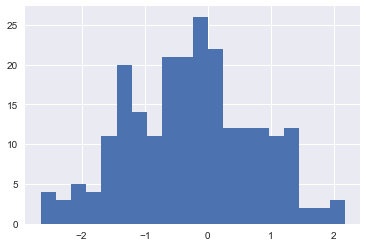

In [61]:
plt.hist(pc1_values_all, bins=20)
plt.show()

In [62]:
pc1_w_sample = []

for sample in zip(rrbs_samples, pc1_values_all):
    pc1_w_sample.append(sample)

In [63]:
pc1_w_sample = sorted(pc1_w_sample, key=lambda x: x[1])

In [64]:
def binned_proportion(sorted_list_of_tupples=None, bin_number=16):
    working_list = list(sorted_list_of_tupples)
    min_value = sorted_list_of_tupples[0][1]
    max_value = sorted_list_of_tupples[-1][1]
    bin_size = (max_value-min_value) / bin_number
    bins = [min_value + bin_size * x for x in range(bin_number)]
    binned_values = [[] for _ in range(bin_number)]
    for value in working_list:
        for count, unique_bin in enumerate(bins):
            if unique_bin <= value[1] < unique_bin + bin_size + .00001:
                binned_values[count].append(value)
    return bins, binned_values

In [65]:
bins, binned_values = binned_proportion(sorted_list_of_tupples=pc1_w_sample, bin_number=6)

In [66]:
for bin in binned_values:
    print(len(bin))

14
40
60
64
41
9


In [67]:
import math

training_samples = []

random_proportion = 0.95

for sample_set in binned_values:
    samples_to_get = int(len(sample_set) * random_proportion)
    print(samples_to_get)
    try:
        random_samples = random.sample(sample_set, samples_to_get) 
    except ValueError:
        random_samples = random.sample(sample_set, len(sample_set)) 
    for sample in random_samples:
        training_samples.append(sample[0])


13
38
57
60
38
8


In [273]:
target_bin = []

for sample in training_samples:
    for count, bin_value in enumerate(binned_values):
        for bin_sample in bin_value:
            if bin_sample[0] == sample:
                target_bin.append(count)    

In [69]:
test_samples = [x for x in rrbs_samples if x not in training_samples]

In [70]:
unaltered_rrbs_phenotypes = whole_cohort_phenotype_data_unaltered.df.loc[[int(x) for x in rrbs_samples]]['dmtype'].values

In [71]:
followup_diabetes_samples = list(welch_comparison_followup_1max[welch_comparison_followup_1max['DiabetesClassifier'] == 'Type 2 Follow-up'].index)

In [72]:
diabetes_rrbs_labels = []
diabetes_samples = []

for sample in zip(rrbs_samples, unaltered_rrbs_phenotypes):
    if int(sample[0]) in followup_diabetes_samples:
        diabetes_rrbs_labels.append(1)
        diabetes_samples.append(sample[0])
    elif sample[1] == 2:
        diabetes_samples.append(sample[0])
        diabetes_rrbs_labels.append(1)
    else:
        diabetes_rrbs_labels.append(0)

## 8. Randomized Lasso

In [272]:
# retrieve sample information
pc1_values = list(whole_pca_values_welch_1max_df.loc[training_samples, 0])
pc2_values = list(whole_pca_values_welch_1max_df.loc[training_samples, 1])

- Test samples picked for seperate runs, training samples are all sequencing sampels not in the testing set


run1_test_samples = ['1530', '1744', '787', '10280', '7366', '7626', '10039', '1974', '5812', '1984', '1757', '1764', '6648', '4544', '5394'] $R^2 = 0.5027$<br>
run2_test_samples = ['2368', '2469', '1004', '1082', '10664', '10070', '1457', '1583', '1445', '1502', '7295', '6515', '5949', '582'] $R^2 = 0.3916$ <br>
run3_test_samples = ['2264', '634', '7366', '1974', '1590', '1653', '5462', '6666', '6684', '6425', '4479', '5460', '569', '6311'] $R^2 = 0.3160$ <br>
Average $R^2 = 0.4034$

In [74]:
# imports
from sklearn import linear_model

In [75]:
meth_test_df = pd.DataFrame(Xhat)
meth_test_df.columns = list(meth_df)

In [76]:
meth_training_df = meth_test_df[training_samples]
meth_training_df.index = meth_df.index

In [77]:
methylation_model_values = meth_training_df[meth_training_df.notnull().all(1)].values

In [78]:
methylation_model_values = np.array(methylation_model_values)

In [79]:
meth_model_df = meth_training_df[meth_training_df.notnull().all(1)]

In [259]:
from sklearn.model_selection import StratifiedKFold
count_threshold = 1
r_resampling = 50
r_selection_threshold = count_threshold / r_resampling
lasso_default_params ={'alpha':'aic', 'sample_fraction': .9, 'normalize':False, 'selection_threshold':r_selection_threshold, 'fit_intercept':True, 'n_resampling':r_resampling, 'scaling':.9, 'n_jobs':1, 'eps':2.2204460492503131e-16}

In [260]:
split_training_samples = [[] for _ in set(target_bin)]

for sample in zip(training_samples, target_bin):
    split_training_samples[sample[1]].append(sample[0])

In [261]:
r_lasso_splits = []

split_denominator = 1

for _ in range(100):
    for count in range(split_denominator):
        temp_list = []
        if count != split_denominator:
            for pc_bin in split_training_samples:
                #random_sample = random.sample(pc_bin, int(len(pc_bin) / split_denominator))
                random_sample = random.sample(pc_bin, int(len(pc_bin) *.7))
                temp_list.extend(random_sample)
                pc_bin = [x for x in pc_bin if x not in random_sample]
        else:
            for pc_bin in split_training_samples:
                temp_list.extend(pc_bin)
        r_lasso_splits.append(temp_list)

In [262]:
# no repeated samples

from sklearn.model_selection import StratifiedKFold
all_scores = []

model_values = np.array(meth_training_df.values.transpose())

randomized_lasso = linear_model.RandomizedLasso(**lasso_default_params)

training_meth_sites = randomized_lasso.fit(model_values, pc1_values) 

all_scores.append(training_meth_sites.scores_)
        

for train_samples in r_lasso_splits:
    model_values = np.array(meth_training_df[train_samples].values.transpose())
    train_set = [training_samples.index(x) for x in train_samples]
    train_target =  [pc1_values[x] for x in train_set]
    training_meth_sites = randomized_lasso.fit(model_values, train_target) 
    all_scores.append(training_meth_sites.scores_)

/home/colin/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [263]:
average_scores = []

for site in zip(*all_scores):
    average_scores.append((np.mean(site), np.var(site)))

In [310]:
average_weights = []

count = 0
for site, score in zip(meth_training_df.index, average_scores):
    count += 1
    if score[0] > 0.3:
        #if score[1] < 0.02:
        average_weights.append((site, score))
    
average_weights = sorted(average_weights, key=lambda x: x[1])
average_weights = average_weights[::-1]

In [311]:
print(average_weights)

[('16:59401242', (0.7114851485148515, 0.08876314086854231)), ('16:16918374', (0.708118811881188, 0.0891578472698755)), ('20:432780', (0.5748514851485149, 0.10943883932947751)), ('19:13337966', (0.5423762376237624, 0.10426366042544848)), ('22:41161987', (0.5401980198019802, 0.09366728752083131)), ('2:209031975', (0.5360396039603961, 0.10518035486716987)), ('X:40872367', (0.5249504950495049, 0.13030816586609154)), ('5:64894449', (0.4619801980198019, 0.11181390059798059)), ('14:22228771', (0.4542574257425742, 0.11690563670228407)), ('9:2717923', (0.4257425742574257, 0.11391157729634348)), ('2:26509616', (0.358019801980198, 0.0843287520831291)), ('4:1320119', (0.3445544554455445, 0.09772579158905992)), ('9:736019', (0.33940594059405943, 0.09851449857857068)), ('16:18931561', (0.33900990099009903, 0.09912377217919813)), ('3:197306028', (0.3287128712871287, 0.09605081854720122)), ('14:82986113', (0.32257425742574264, 0.11130030389177532)), ('2:91704042', (0.3160396039603961, 0.09646748358004

In [313]:
t2d_sites = []

for count, site in enumerate(average_weights):
    t2d_sites.append(site[0])
    print(site[0])

16:59401242
16:16918374
20:432780
19:13337966
22:41161987
2:209031975
X:40872367
5:64894449
14:22228771
9:2717923
2:26509616
4:1320119
9:736019
16:18931561
3:197306028
14:82986113
2:91704042
10:90989278


## 9. CV Regression Model
- Selected accross runs <br>
run1_cpg_sites = ['16:59401242', '9:736019', '2:209031975', '16:16918374', '9:105004836', '2:26509616', '9:2717923', '14:82986113', '20:52152081', '1:208913348', '10:51546335', '3:197306028', '20:432780']<br>
run2_cpg_sites = ['16:59401242', '16:16918374', '20:432780', '19:13337966', '22:41161987', '2:209031975','X:40872367', '5:64894449', '14:22228771', '9:2717923', '2:26509616', '4:1320119', '9:736019', '16:18931561', '3:197306028', '14:82986113', '2:91704042', '10:90989278'] <br>
run3_cpg_sites =  ['2:209031975', '16:59401242', '14:82986113', '19:13337966', '22:41161987', '5:64894449', '22:49812148', '2:26509616', '12:1781211', '16:16918374', '3:197306028']

In [274]:
t2d_sites = run2_cpg_sites
test_samples = run2_test_samples
training_samples = [x for x in rrbs_samples if x not in test_samples]

In [275]:
meth_training_df = meth_df[training_samples]

In [276]:
# initialized dataframe with methylation values for selected
meth_regression = meth_training_df.loc[t2d_sites]
meth_regression = meth_regression.dropna(axis = 0)
meth_regression =  meth_regression[pd.notnull(meth_regression)]
meth_regression_values = np.transpose(meth_regression.values)

In [277]:
from sklearn.model_selection import StratifiedKFold
splits = 5
validation_regressor = linear_model.LinearRegression()
kf = StratifiedKFold(n_splits=splits, random_state=None, shuffle=False)
model_coefficients = []
intercepts = []
for train_set, test_set in kf.split(meth_regression_values, target_bin):
    validation_regressor.fit(np.asarray(meth_regression_values)[train_set], np.asarray(pc1_values)[train_set])
    predicted_value = validation_regressor.predict(meth_regression_values[test_set])
    print(validation_regressor.score(np.asarray(meth_regression_values)[test_set], np.asarray(pc1_values)[test_set]))
    model_coefficients.append(list(validation_regressor.coef_))
    intercepts.append(validation_regressor.intercept_)

0.5746398863559387
0.47475772168664526
0.3947465608983204
0.39677010496321086
0.4007203240141676


In [278]:
transposed_coefficients = list(map(list, zip(*model_coefficients)))
average_coefficients = []
coefficient_variance = []
bad_sites = []

for count, site in enumerate(transposed_coefficients):
    tmp_list = []
    average_coefficients.append(round(float(np.mean(site)),4))
    
average_intercept = round(float(np.mean(intercepts)),4)

In [279]:
predicted_values = []

for sample in training_samples:
    temp_sites = []
    sample_df = meth_regression[sample]
    for sites in zip(average_coefficients, sample_df.values):
        temp_sites.append(sites[0] * sites[1])
    predicted_values.append(sum(temp_sites) + average_intercept)

In [280]:
measured_values =  list(whole_pca_values_welch_1max_df.loc[training_samples, 0])

In [281]:
print(len(predicted_values))
print(len(training_samples))

214
214


In [282]:
print(r2(predicted_values, measured_values))

0.5325633276524696


In [283]:
meth_test_df = meth_df.loc[list(meth_regression.index)]
meth_test_df = meth_test_df[test_samples]

In [284]:
test_pc1_values = list(whole_pca_values_welch_1max_df.loc[test_samples, 0])

In [285]:
test_prediction = []

for sample in test_samples:
    temp_sites = []
    sample_df = meth_test_df[sample]
    for sites in zip(average_coefficients, sample_df.values):
        temp_sites.append(sites[0] * sites[1])
    test_prediction.append(sum(temp_sites) + average_intercept)

In [286]:
print(r2(test_prediction, test_pc1_values))

0.3892110952108236


In [230]:
print(test_samples)

['2368', '2469', '1004', '1082', '10664', '10070', '1457', '1583', '1445', '1502', '7295', '6515', '5949', '582']


In [269]:
# regression coefficients accross three runs
print(coefficient_dict)

{'16:59401242': [-0.5143, -0.4369, -0.3741], '16:16918374': [-0.5193, -0.53, -0.4926], '20:432780': [0.3349, 0.4792], '19:13337966': [0.6587, 0.6224], '22:41161987': [0.2423, 0.2987], '2:209031975': [-0.907, -0.8944, -0.9962], 'X:40872367': [-0.3278], '5:64894449': [0.2673, 0.3724], '14:22228771': [-0.2528], '9:2717923': [-0.4419, -0.4622], '2:26509616': [-0.6941, -0.6573, -0.752], '4:1320119': [-0.1613], '9:736019': [0.5391, 0.4212], '16:18931561': [0.1073], '3:197306028': [0.5411, 0.5239, 0.6006], '14:82986113': [-0.4934, -0.5708, -0.6523], '2:91704042': [0.3883], '10:90989278': [-0.1355], '9:105004836': [-0.4448], '20:52152081': [0.4019], '1:208913348': [-0.5426], '10:51546335': [-0.4951], '22:49812148': [0.3805], '12:1781211': [-0.5917]}


## 10. Export Sites a BED file for GREAT Annotation

## 11. Figure

In [287]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["font.family"] = "Times New Roman"
sns.set(style="white")


In [288]:
from sklearn.metrics import roc_curve, auc

In [289]:
unaltered_rrbs_phenotypes = whole_cohort_phenotype_data_unaltered.df.loc[[int(x) for x in test_samples]]['dmtype'].values

In [290]:
diabetes_rrbs_labels = []

for sample in zip(test_samples, unaltered_rrbs_phenotypes):
    if int(sample[0]) in followup_diabetes_samples:
        diabetes_rrbs_labels.append(1)
    elif sample[1] == 2:
        diabetes_rrbs_labels.append(1)
    else:
        diabetes_rrbs_labels.append(0)

In [291]:
fpr_predicted, tpr_predicted, _ = roc_curve(diabetes_rrbs_labels, test_prediction)
fpr_actual, tpr_actual, _ = roc_curve(diabetes_rrbs_labels, test_pc1_values)
predicted_auc = auc(fpr_predicted, tpr_predicted)
actual_auc = auc(fpr_actual, tpr_actual)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


### PC1 Comparison VS Traditional Diagnostic Measures
- P_gl0, Oral Glucose Tolerance Test - Fasting
- P_gl120, Oral Glucose Tolerance Test - 120min 
- B_GHbA1C, Blood GHbA1C

In [292]:
common_diagnostic_metrics = {'P_gl0': 'OGTT Fasting', 'P_gl120': 'OGTT 120min', 'B_GHbA1C': 'Blood GHbA1C'} 

In [293]:
roc_comparison_df = welch_comparison_followup_1max.copy()
print(len(roc_comparison_df.index))
roc_comparison_df = roc_comparison_df.apply(pd.to_numeric, errors='ignore')
roc_comparison_df = roc_comparison_df.replace(' ', np.nan)
for feature in common_diagnostic_metrics.keys():
    roc_comparison_df = roc_comparison_df[roc_comparison_df[feature].notnull()]

2422


In [294]:
comparison_diabetes = []

for sample in list(roc_comparison_df['DiabetesClassifier']):
    if sample == 'Healthy':
        comparison_diabetes.append(0)
    else:
        comparison_diabetes.append(1)

In [295]:
followup_pc1_values = list(roc_comparison_df['PC1'])

In [296]:
fpr_followup_traits_pc1, tpr_followup_traits_pc1, _ = roc_curve(comparison_diabetes, followup_pc1_values)
folowup_auc = auc(fpr_followup_traits_pc1, tpr_followup_traits_pc1)

In [297]:
comparison_pc1_values = list(roc_comparison_df['PC1'])

In [298]:
roc_comparison = []

for feature in common_diagnostic_metrics.keys():
    fpr_temp, tpr_temp, _ = roc_curve(comparison_diabetes, list([float(x) for x in roc_comparison_df[feature]]))
    temp_auc = auc(fpr_temp, tpr_temp)
    roc_comparison.append([fpr_temp, tpr_temp, temp_auc])

In [299]:
import matplotlib.cm as cm
trait_color_spectrum = list(cm.nipy_spectral(np.linspace(0, 1, len(common_diagnostic_metrics))))

### Figure 5

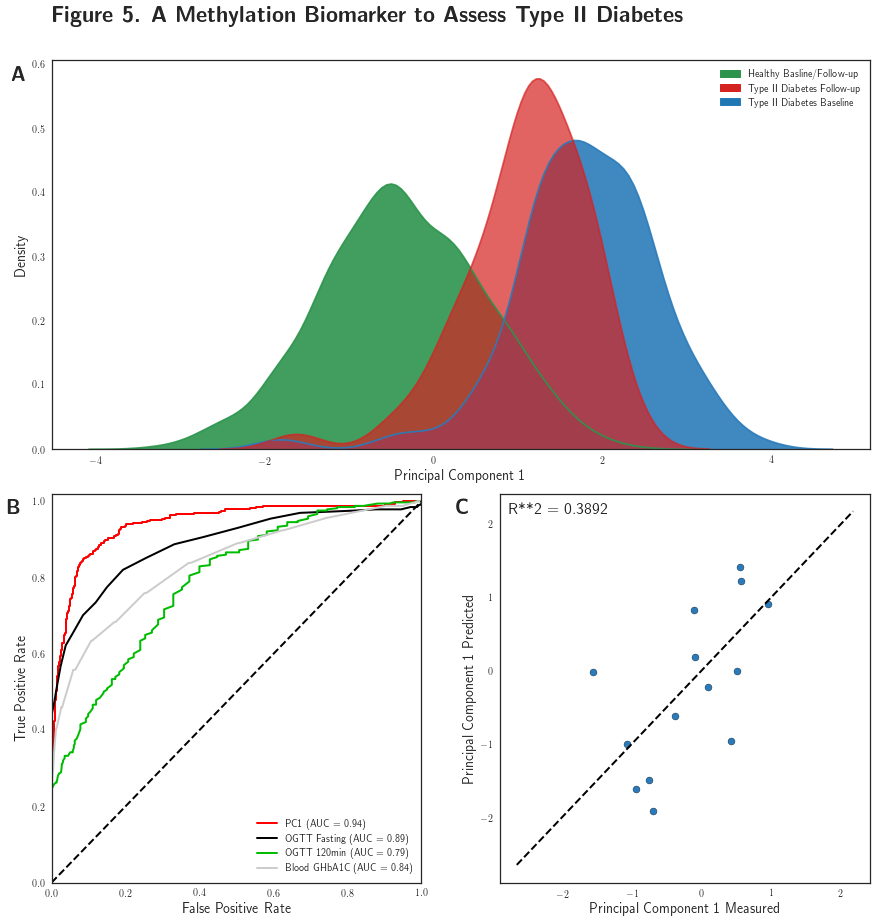

In [301]:
fig, axes = plt.subplots(sharex=False, figsize=(12,12))

lw = 2

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)


sns.kdeplot(healthy['PC1'], shade=True,shade_lowest=False, alpha=.9, ax=ax1, color=sns.color_palette("Greens")[-2])
sns.kdeplot(type2_baseline['PC1'], shade=True,shade_lowest=False, alpha=.9,ax=ax1, color=sns.color_palette("Blues")[-2])
sns.kdeplot(type2_followup['PC1'], shade=True,shade_lowest=False, alpha=.7,ax=ax1, color=sns.color_palette("Reds")[-2])
L = ax1.legend(handles=[green_patch, red_patch, blue_patch])
L.get_texts()[0].set_text('Healthy Basline/Follow-up')
L.get_texts()[1].set_text('Type II Diabetes Follow-up')
L.get_texts()[2].set_text('Type II Diabetes Baseline')
ax1.set_xlabel('Principal Component 1', fontsize=14) 
ax1.set_ylabel('Density', fontsize=14)
fig.tight_layout()

plt.sca(ax2)        
ax2.plot(fpr_followup_traits_pc1, tpr_followup_traits_pc1, color='red',
         lw=lw, label='PC1 (AUC = %0.2f)' % folowup_auc)
for count, feature in enumerate(roc_comparison):
    ax2.plot(feature[0], feature[1], color=trait_color_spectrum[count],
             lw=lw, label='%s (AUC = %0.2f)' % (common_diagnostic_metrics[list(common_diagnostic_metrics.keys())[count]] , feature[2])) 
ax2.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
ax2.set_ylabel('True Positive Rate', fontsize=14)
ax2.set_xlabel('False Positive Rate', fontsize=14)
ax2.legend(loc="lower right")


ax3.scatter(test_prediction, test_pc1_values, edgecolors=(0, 0, 0), color=sns.color_palette("Blues")[-2])
plot_fit = r2(test_prediction, test_pc1_values)
plot_fit = 'R**2 = ' + str(round(plot_fit,4))
ax3.text(0.025, .95, plot_fit,transform=ax3.transAxes, fontsize=16)
ax3.plot([np.asarray(pc1_values).min(), np.asarray(pc1_values).max()], [np.asarray(pc1_values).min(), np.asarray(pc1_values).max()], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
ax3.set_xlabel('Principal Component 1 Measured', fontsize=14)
ax3.set_ylabel('Principal Component 1 Predicted', fontsize=14)




label_position_y = .95
label_position_x = -0.12
label_font_size = 20

ax1.text(0.0, 1.1, '\\textbf{Figure 5. A Methylation Biomarker to Assess Type II Diabetes}',transform=ax1.transAxes, fontsize=label_font_size+2)

#figure_caption = ('\\begin{minipage}{0.16\linewidth}\\textbf{Figure 5. Methylation Biomarker to Assess Type II Diabetes.}' + caption_text + '\\end{minipage}')
#ax3.text(0, -.35, figure_caption, transform=ax3.transAxes, fontsize=12)



ax1.text(-.05, label_position_y, '\\textbf{A}', transform=ax1.transAxes, weight='bold', fontsize=label_font_size)
ax2.text(label_position_x, label_position_y, '\\textbf{B}', transform=ax2.transAxes, weight='bold', fontsize=label_font_size)
ax3.text(label_position_x, label_position_y, '\\textbf{C}', transform=ax3.transAxes, weight='bold', fontsize=label_font_size)


plt.tight_layout(pad=0.4, w_pad=3, h_pad=1.0)

plt.savefig('Figure5_updated.png', bbox_inches='tight', dpi=300)
plt.show()